# KOIOS
## Basic engine implementation
* Detecting the heart rate of a patient using signal processing and machine learning
* Project number: 87
* By Perry Tubul 205874290 and Eyal Golan 204229223

# Table of Contents
1. [Basic engine implementation](#Basic)
2. [Setup](#Setup)
3. [Engine and HR detection](#Engine)

# <a class="anchor" id="Basic">1. Basic engine implementation</a>
Heart rate detection - basic: a basic heart rate detection in optimal conditions

# <a class="anchor" id="Setup">2. Setup</a>
#### Initializing the Logger, reading the videos location and detecting the OS

In [1]:
import face_recognition, PIL.Image, PIL.ImageDraw,math
import numpy as np
import logging
import cv2
import platform
from matplotlib import pyplot as plt
import scipy.signal as sig
import os

FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"

with open("input_path_basic.txt") as input_file:
    video_source = input_file.read()

[2021-08-01 19:20:57,954] [INFO] [<module>] [13] : Starting ...


## evm pre-processing

In [2]:
#%run ./evm_preprocessing.ipynb
# video_location = dataset_location + specific_dir + seperator + "out.avi"
#video_location="out2.avi"

# <a class="anchor" id="Engine">3. Engine</a>
## 3.1 ROI detection
Detects face landmarks and parsing the ROI

In [3]:
def parse_roi(frame):
    """
    Find a face and its region of interests.  
    @param frame: A video frame
    @return: None in case of which no face was detected. A tuple in a form of (forehead, nose_to_upper_lip) 
    forehead is ndarray that represents the subject's forehead, nose_to_upper_lip is ndarray that represents the region
    between the upper lip and the nose of the subject. 
    """
    # image = face_recognition.load_image_file(frame) # read image.
    face_locations = face_recognition.face_locations(frame,model = 'hog') # detects all the faces in image
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    # iterate through all the faces.
    for face_location in face_locations:
        img = PIL.Image.fromarray(frame)
        top,right,bottom,left = face_location # extract all face square points.
        diff = math.floor((top - bottom) * 0.15) # 20 percent of the face len (to add eyebrow top point).
        
        # finding the forehead
        try:
            right_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['right_eyebrow']) # right eyebrow points.
        except Exception as e:
            logging.warning(str(e))
            return None
        right_eyebrow_landmarks.sort(axis=0)
        rightest_point = right_eyebrow_landmarks[-1] # The most right point of the ROI(according to x).
        top_right_eyebrow = right_eyebrow_landmarks.min(axis = 0)[1]
        try:
            left_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['left_eyebrow'])
        except Exception as e:
            logging.warning(str(e))
            return None
        left_eyebrow_landmarks.sort(axis=0)
        leftest_point = left_eyebrow_landmarks[0] # the most left point of ROI.(according to x)
        top_left_eyebrow = left_eyebrow_landmarks.min(axis = 0)[1]
        bottom = min(top_right_eyebrow,top_left_eyebrow).item(0) # bottom point of the forehead.
        bottom = bottom - (0.05 * bottom) # improve bottom location by 2 percent.
        forehead = img.crop((leftest_point[0], leftest_point[1]+diff, rightest_point[0],bottom+10)) # adding diff to top to make the forehead bigger.

        # finding the second ROI:
        try:
            upper_mouth = np.asarray(face_landmarks_list[0]['top_lip']) # top_lip landmarks
        except Exception as e:
            logging.warning(str(e))
            return None
        upper_mouth_min = upper_mouth.min(axis = 0)[1] # The  top - lip upper point.
        try:
            upper_nose = np.asarray(face_landmarks_list[0]['nose_bridge'])
        except Exception as e:
            logging.warning(str(e))
            return None
        upper_nose_min = upper_nose.min(axis = 0)[1]  # noise bridge upper point.
        upper_nose_min += upper_mouth_min * 0.1 # improving the noise bridge upper point.
        nose_to_upper_lip = img.crop((leftest_point[0], upper_nose_min, rightest_point[0], upper_mouth_min))

        return forehead, nose_to_upper_lip
    return None # in case of which no face was detected

## 3.2 Check for bad frames
* Criteria is:  R > 95 and G > 40 and B > 20 and R > G and R > B
* Based on https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf page 5

In [4]:
red_min_val = 95
green_min_val = 40
blue_min_val = 20
red_green_max_diff = 15
def good_frame(blue, green, red):
    """
        Checks the light conditions 
        @param: blue Is the mean of all the blue pixels in one frame
        @param: green Is the mean  of all the green pixels in one frame
        @param: red Is the mean of all the red pixels in one frame
        return False 0 meaning the lightning are bad, True when the lightning condition are OK
    """
    if red <= red_min_val:
        logging.warning("bad frame detected, reason: red > red_min_val")
        return False
    if green <= green_min_val:
        logging.warning("bad frame detected, reason: green > green_min_val")
        return False
    if blue <= blue_min_val:
        logging.warning("bad frame detected, reason: blue > blue_min_val")
        return False
    if red <= green:
        logging.warning("bad frame detected, reason: red > green")
        return False
    if red <= blue:
        logging.warning("bad frame detected, reason: red > blue")
        return False
    if abs(red - green) <= red_green_max_diff:
        logging.warning("bad frame detected, reason: abs(red - green) > red_green_max_diff")
        return False
    return True

In [5]:
def get_new_frame(vidcap):
    """
    Reads new video frame and return it.
    @param vidcap: Pointer to the video 
    @return True, Image where there is more frames in the video to be read else False, None 
    """
    success, next_image = vidcap.read()
    return success, next_image

## 3.3 Plotting RGB arrays

In [6]:
def plot_result(greens, reds, blues, x_value, title=""):
    """
    Generic function to plot graphs.
    @param greens: 1D array, greens[i] is the mean of all the green color in frame i 
    @param reds: 1D array, reds[i] is the mean of all the red color in frame i
    @param blues:1D array, blues[i] is the mean of all the blue color in frame i
    @param x_value: 1D array for the X- axis
    @param title: Title of the plot default is ""
    @return: None
    """
    logging.info("Plotting results ..." + title)
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x_value, greens, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x_value, reds, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x_value, blues, color="blue")
    plt.show()
    logging.info("Showing result")

## 3.4 Channel filtering

In [7]:
def filter_channel(channel,fs):
    """
    This method apply filter on a channel between 0.75HZ to 4HZ.
    :param channel: Is a signal to apply the filter to.
    :param fs: Is the sampling rate of channel.
    :return: The filtered channel.
    """
    bh, ah = sig.butter(4, 0.75 / (fs / 2), 'highpass')
    bl, al = sig.butter(4, 4 / (fs / 2), 'lowpass')
    channel = sig.filtfilt(bh, ah, channel) # applying the filter coefficient on the sig
    channel_after_filter = sig.filtfilt(bl, al, channel) # applying the filter coefficient on the sig
    return channel_after_filter

## 3.5 Get RGB values from a frame and Check light conditions

In [8]:
def parse_luminace(red, green, blue):
    """
    Calculate frame's luminace
    :param red: Mean value of all pixels in the red channel
    :param green: Mean value of all pixels in the green channel
    :param blue: Mean value of all pixels in the blue channel
    :return: The luminace value
    """
    luminance_level = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    return luminance_level

def parse_RGB(roi, color_sig):
    """
    Calculate all the mean value of the green channel in ROI.
    :param roi: Area that we used to extract HR
    :param color_sig: is the 
    :return: False in case there is an error, color_sig and luminace value
    """
    try:
        roi = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR)
    except Exception as e:
        logging.warning(str(e))
        return False, color_sig
    new_blue,new_green,new_red = cv2.split(roi) # get all the colors of the frame
    b_mean,g_mean,r_mean = np.mean(new_blue),np.mean(new_green),np.mean(new_red) # calculate the of each array
    luminance_level = parse_luminace(r_mean, g_mean, b_mean) 
    if good_frame(b_mean,g_mean,r_mean): # check the lightinig condition
        color_channels = roi.reshape(-1, roi.shape[-1])
        avg_color = color_channels.mean(axis=0)
        color_sig.append(avg_color)
        return True, color_sig, luminance_level
    return False, color_sig, luminance_level

## 3.6 Main loop - Heart rate signal extraction

In [9]:
color_sig = []
heart_rates = []
good_frame_number = 0
total_frame_number = 0

# Parsing video:
logging.info("Working on video " + video_source)
vidcap = cv2.VideoCapture(video_source) # get video object
success, image = vidcap.read() # read the first video frame
fps = vidcap.get(cv2.CAP_PROP_FPS) # fs == sampling rate
round_fps = np.round(fps)
number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
logging.info("Parsing images ...")
while success: # iterate as long as there is a frame to process
    logging.info("parsing frame " + str(total_frame_number) + "/" + str(number_of_frames))
    rois = parse_roi(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # build image ROI (rois is a tuple contains two regions)
    if rois is not None :
        roi = np.asarray(rois[0]) # Just the forehead - we decided that it's best to choose the forehead more consistent results.
        is_good_frame,color_sig, luminance_level = parse_RGB(roi, color_sig)
        if is_good_frame:
            good_frame_number += 1 # keep track of the goof frames, for plotting later
            logging.info("luminance level: " + str(luminance_level))
    total_frame_number += 1
    success, image = get_new_frame(vidcap) # read next frame

[2021-08-01 19:20:58,082] [INFO] [<module>] [7] : Working on video C:\Users\eyalg\Downloads\dataset\subject4\vid.avi
[2021-08-01 19:20:58,082] [INFO] [<module>] [13] : Parsing images ...
[2021-08-01 19:20:58,098] [INFO] [<module>] [15] : parsing frame 0/2028.0
[2021-08-01 19:20:58,378] [INFO] [<module>] [22] : luminance level: 174.6998475
[2021-08-01 19:20:58,378] [INFO] [<module>] [15] : parsing frame 1/2028.0
[2021-08-01 19:20:58,647] [INFO] [<module>] [22] : luminance level: 174.55192952380952
[2021-08-01 19:20:58,647] [INFO] [<module>] [15] : parsing frame 2/2028.0
[2021-08-01 19:20:58,946] [INFO] [<module>] [22] : luminance level: 174.40934
[2021-08-01 19:20:58,946] [INFO] [<module>] [15] : parsing frame 3/2028.0
[2021-08-01 19:20:59,218] [INFO] [<module>] [22] : luminance level: 174.66350214285714
[2021-08-01 19:20:59,218] [INFO] [<module>] [15] : parsing frame 4/2028.0
[2021-08-01 19:20:59,495] [INFO] [<module>] [22] : luminance level: 174.25651021087683
[2021-08-01 19:20:59,495

## 3.7 support function for plotting the results

In [10]:
def print_results(frames_window, window, xlabel, ylabel, change_range):
    """
    Generic function that plots signals for a 30 seconds window
    @param frames_window: 1D array represent the seconds in the window 
    @param window:HR 30 seconds signal 
    @param xlabel: label to be shown in the X - axis
    @param ylabel: label to be shown in the Y - axis
    @param change_range:
    @return: None
    """
    fig = plt.figure(figsize=(20,6))
    ax = fig.subplots()
    while len(frames_window) > len(window):
        frames_window = frames_window[-1]
    ax.plot(frames_window,window,color ='green')
    if change_range:
        plt.xlim([0, 5])
    # add some data to the signal 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale('linear')
    ax.spines['bottom'].set_color('red')
    ax.spines['left'].set_color('red')
    ax.xaxis.label.set_color('red')
    ax.yaxis.label.set_color('red')
    ax.tick_params(axis='x', colors='red')
    ax.tick_params(axis='y', colors='red')
    plt.show()

## 3.8 Split the signal into windows and find HR in each window

In [11]:
def find_hr_in_window(green, window_start, round_fps, window_id, window_size):
    """
    Split the signal into windows and find HR in each window
    :param green: is the signal of the all video
    :param window_start: index of where the window start in green
    :param round_fps: round frames per seconds
    :param window_id: window number
    :param window_size: size of the window - 30 seconds or less if there are not enough frames
    :return: None
    """
    round_fps = int(round_fps)
    # find the window:
    if window_start + round_fps * window_size > len(green):
        window = green[window_start : ]
    else:
        window = green[window_start : window_start + round_fps * window_size]
    frames_window = np.arange(window.size/round_fps,step= (1/round_fps))
    #plot the window:
    print_results(frames_window, window, 'X-axis', 'Y-axis', False)
    # normalize window signal
    window = window - np.mean(window)
    window = window / np.std(window)
    print_results(frames_window, window, 'X-axis', 'Y-axis', False)
    # filter the signal and plot results
    g = filter_channel(window,round_fps)
    print_results(frames_window, g, 'X-axis', 'Y-axis', False)
    f, Pxx_den = sig.periodogram(g, round_fps) # find the frequencies in the signal
    #plot the frequencies:
    print_results(f, Pxx_den, 'frequency [Hz]', 'PSD [V**2/Hz]', True) 
    # find the maximum freq.
    max_val = Pxx_den.argmax()
    logging.info("Heart rate of window " + str(window_id) +
                 ": " + str(f[max_val]))

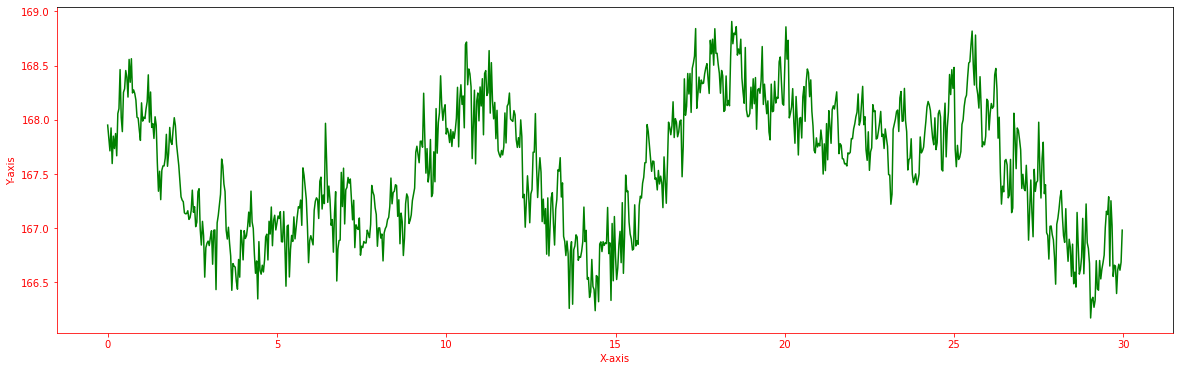

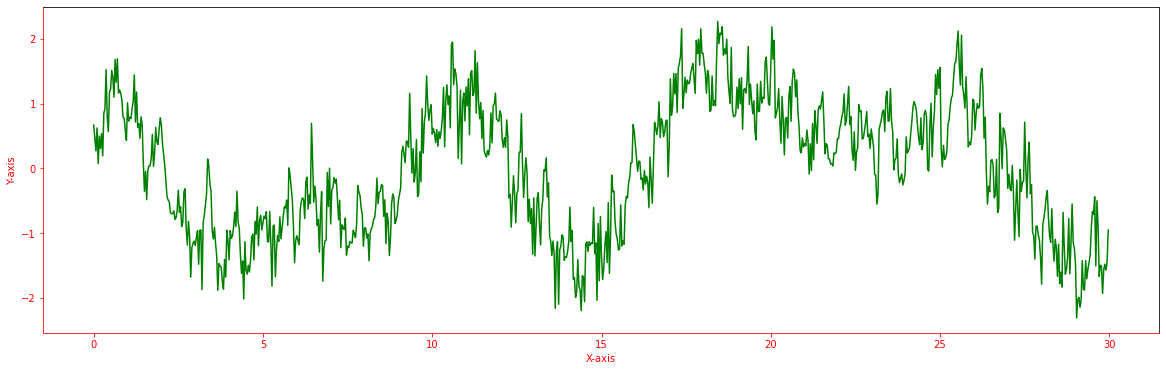

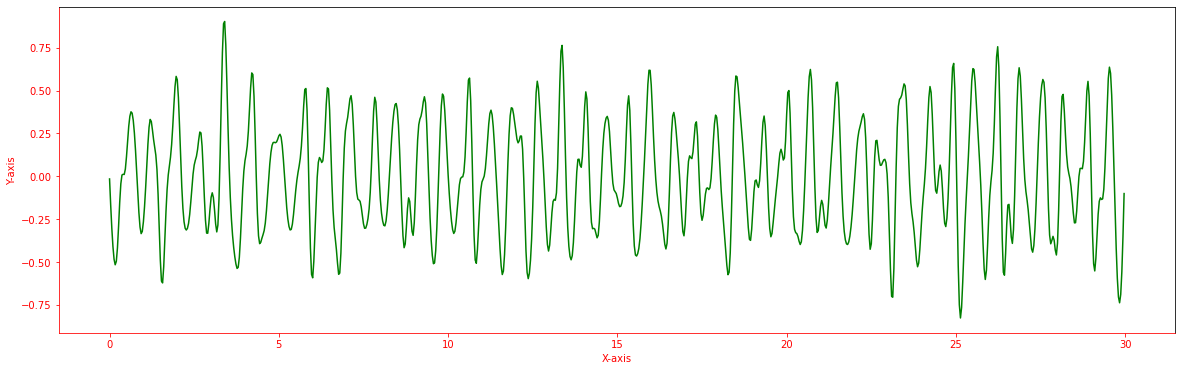

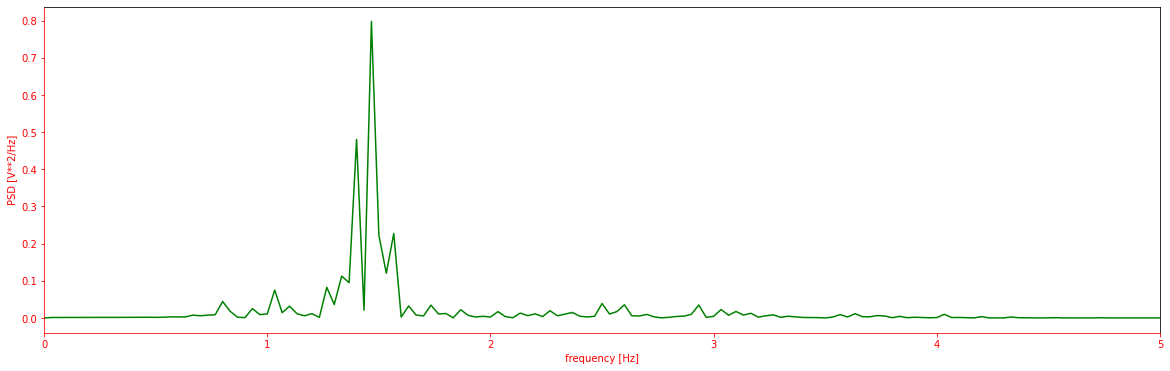

[2021-08-01 19:35:48,358] [INFO] [find_hr_in_window] [32] : Heart rate of window 0: 1.4666666666666666


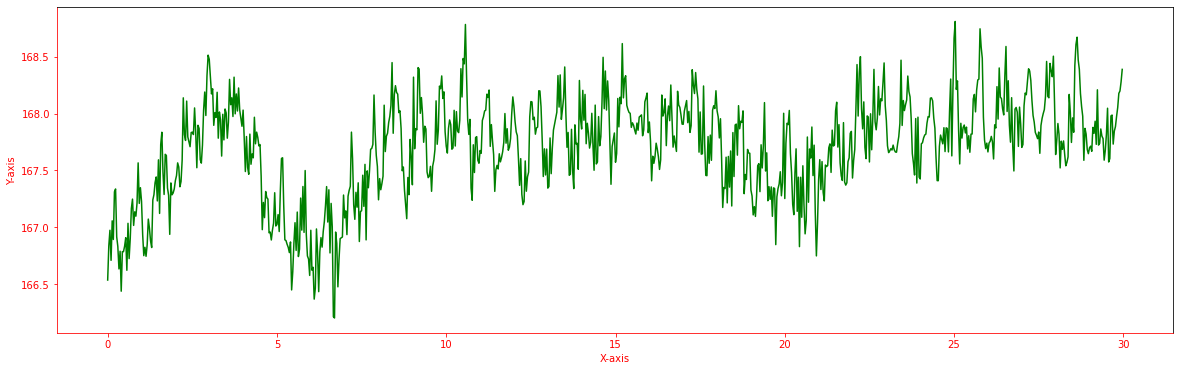

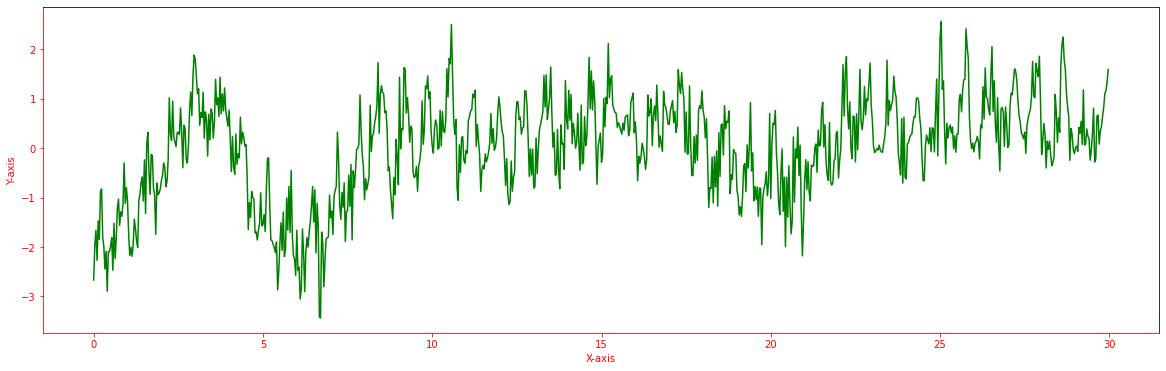

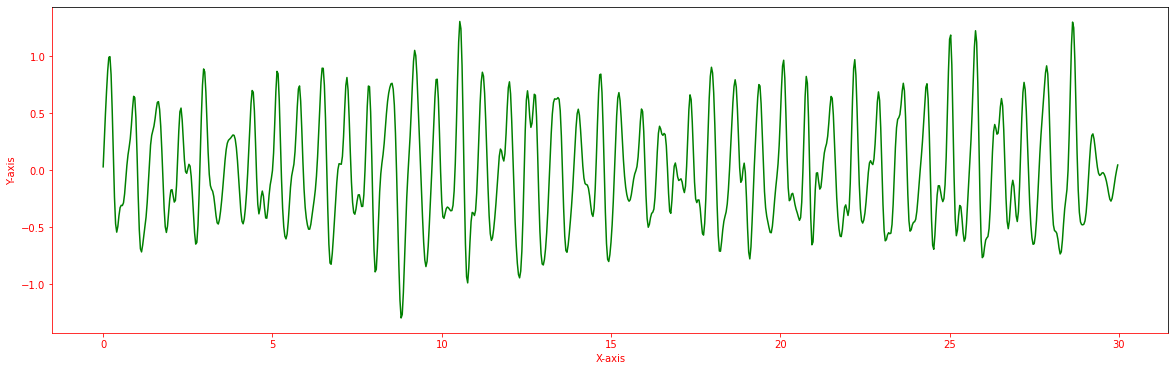

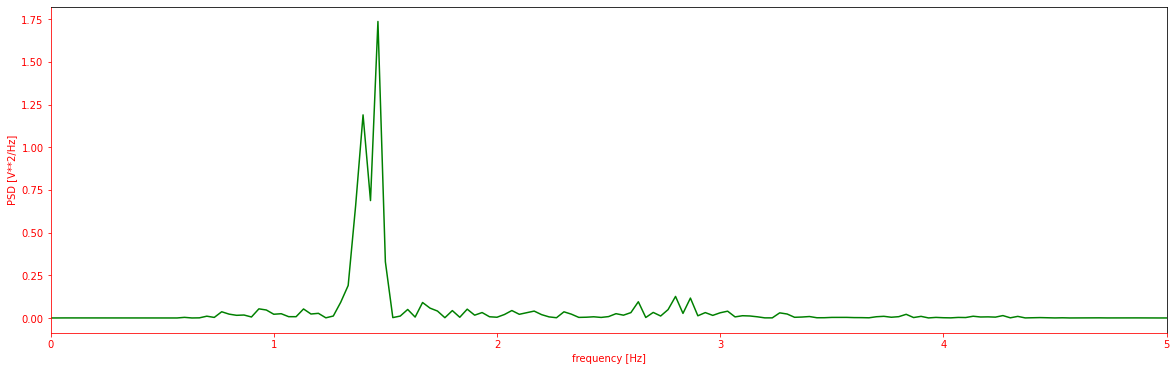

[2021-08-01 19:35:49,214] [INFO] [find_hr_in_window] [32] : Heart rate of window 1: 1.4666666666666666


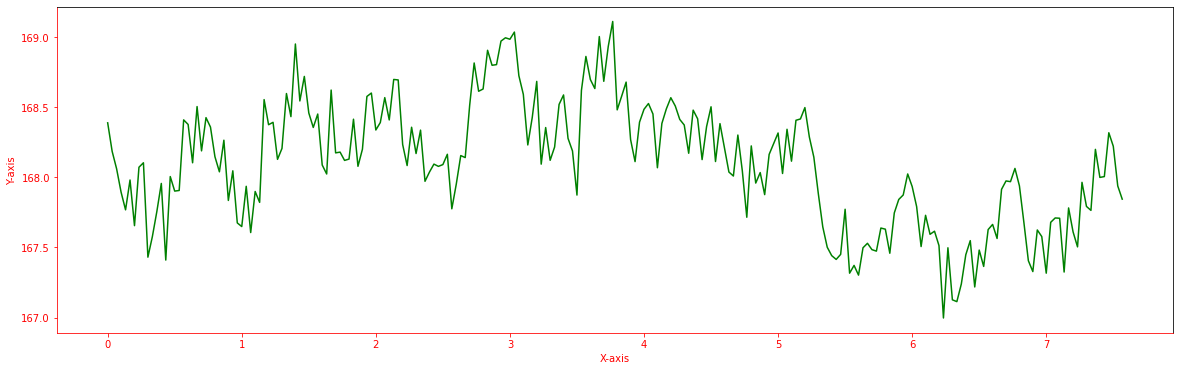

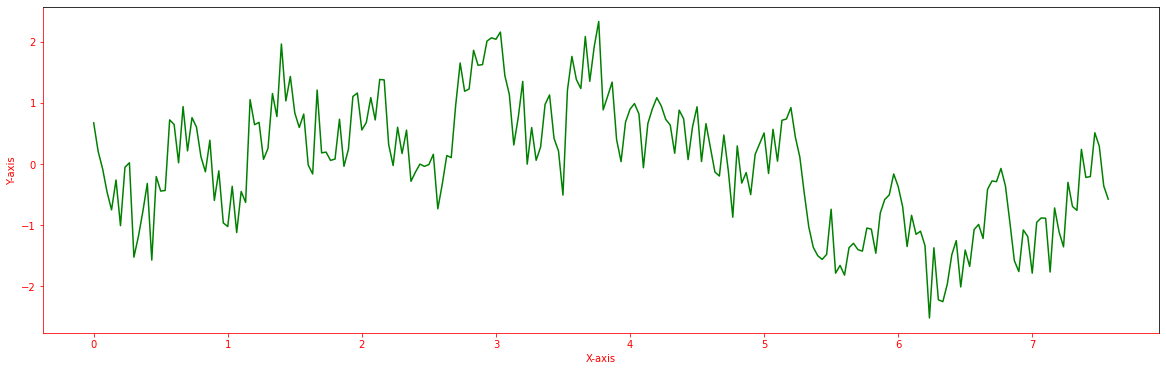

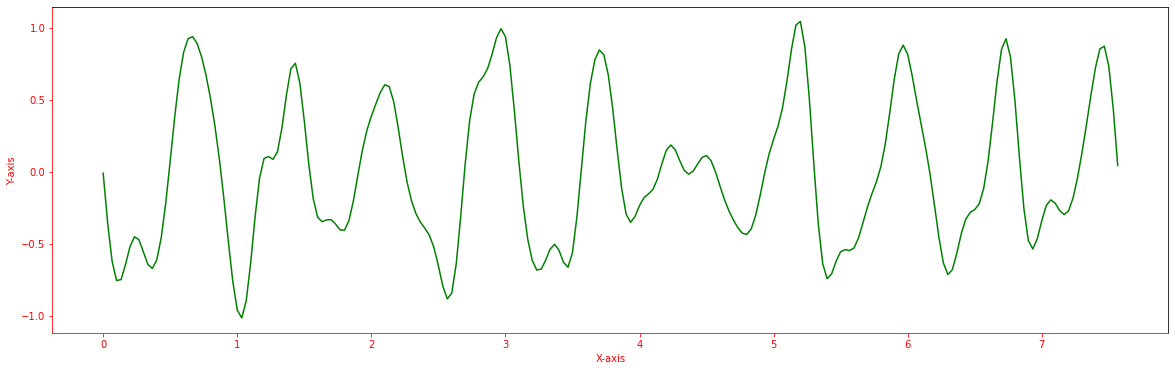

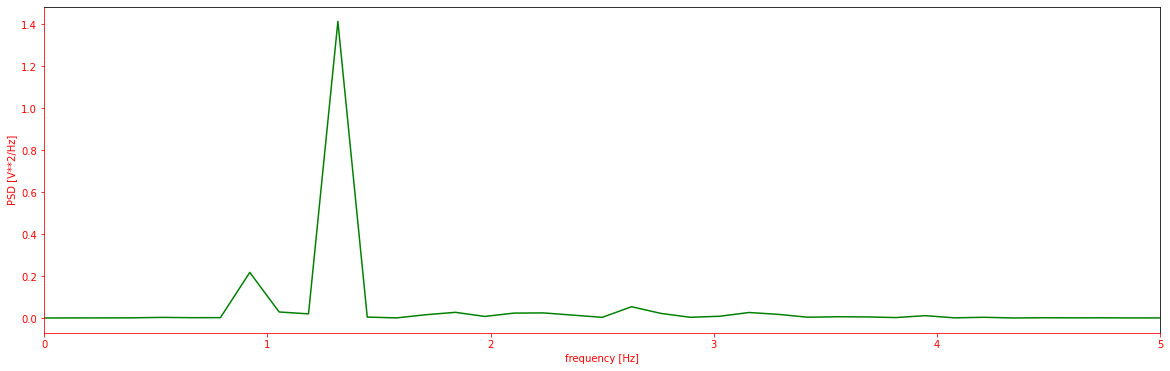

[2021-08-01 19:35:50,039] [INFO] [find_hr_in_window] [32] : Heart rate of window 3: 1.3157894736842104


In [12]:
color_sig_array = np.asarray(color_sig)
red = color_sig_array[:,0]
green = color_sig_array[:,1]
blue = color_sig_array[:,2]

window_start = 0
window_size = 30
window_id = 0
limit = good_frame_number - int(round_fps) * window_size
while window_start < limit :
    find_hr_in_window(green, window_start, round_fps, window_id, window_size)
    window_start += int(round_fps) * window_size
    window_id += 1
if window_start < good_frame_number:
    window_id += 1
    find_hr_in_window(green, window_start, round_fps, window_id, good_frame_number - window_start)

## 3.9 Peaks detection in the signal + write to csv the times

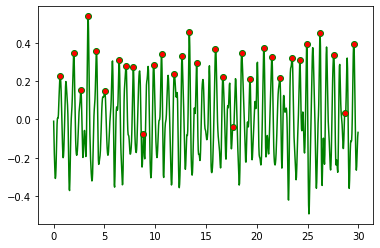

[ 0.63333333  1.96666667  2.66666667  3.4         4.2         5.03333333
  6.43333333  7.13333333  7.83333333  8.83333333  9.83333333 10.63333333
 11.86666667 12.63333333 13.36666667 14.06666667 15.93333333 16.66666667
 17.66666667 18.5        19.33333333 20.7        21.5        22.26666667
 23.46666667 24.23333333 24.93333333 26.23333333 27.56666667 28.66666667
 29.53333333]


In [13]:
def indexes(y, thres=0.3, min_dist=1, thres_abs=False):
    """
    Finds the peaks in the signal
    :param y:  is the signal
    :param thres: minimum height of the peaks
    :param min_dist: minimum distance between each peek 
    :param thres_abs: 
    :return: array of all the peaks
    """
    if isinstance(y, np.ndarray) and np.issubdtype(y.dtype, np.unsignedinteger):
        raise ValueError("y must be signed")

    if not thres_abs:
        thres = thres * (np.max(y) - np.min(y)) + np.min(y)

    min_dist = int(min_dist)

    # compute first order difference
    dy = np.diff(y)

    # propagate left and right values successively to fill all plateau pixels (0-value)
    zeros, = np.where(dy == 0)

    # check if the signal is totally flat
    if len(zeros) == len(y) - 1:
        return np.array([])

    if len(zeros):
        # compute first order difference of zero indexes
        zeros_diff = np.diff(zeros)
        # check when zeros are not chained together
        zeros_diff_not_one, = np.add(np.where(zeros_diff != 1), 1)
        # make an array of the chained zero indexes
        zero_plateaus = np.split(zeros, zeros_diff_not_one)

        # fix if leftmost value in dy is zero
        if zero_plateaus[0][0] == 0:
            dy[zero_plateaus[0]] = dy[zero_plateaus[0][-1] + 1]
            zero_plateaus.pop(0)

        # fix if rightmost value of dy is zero
        if len(zero_plateaus) and zero_plateaus[-1][-1] == len(dy) - 1:
            dy[zero_plateaus[-1]] = dy[zero_plateaus[-1][0] - 1]
            zero_plateaus.pop(-1)

        # for each chain of zero indexes
        for plateau in zero_plateaus:
            median = np.median(plateau)
            # set leftmost values to leftmost non zero values
            dy[plateau[plateau < median]] = dy[plateau[0] - 1]
            # set rightmost and middle values to rightmost non zero values
            dy[plateau[plateau >= median]] = dy[plateau[-1] + 1]

    # find the peaks by using the first order difference
    peaks = np.where(
        (np.hstack([dy, 0.0]) < 0.0)
        & (np.hstack([0.0, dy]) > 0.0)
        & (np.greater(y, thres))
    )[0]

    # handle multiple peaks, respecting the minimum distance
    if peaks.size > 1 and min_dist > 1:
        highest = peaks[np.argsort(y[peaks])][::-1]
        rem = np.ones(y.size, dtype=bool)
        rem[peaks] = False

        for peak in highest:
            if not rem[peak]:
                sl = slice(max(0, peak - min_dist), peak + min_dist + 1)
                rem[sl] = True
                rem[peak] = False

        peaks = np.arange(y.size)[~rem]
    return peaks

green_buttered = filter_channel(green,round_fps)
x = np.arange(window_size,step=1/round_fps)
while len(x) > len(green_buttered):
        x = x[:-1]
while len(green_buttered) > len(x):
        green_buttered = green_buttered[:-1]
peaks = indexes(green_buttered,min_dist=20)
plt.plot(x,green_buttered,'-go',markerfacecolor='red',markevery=peaks)
plt.show() 
print(x[peaks])
np.savetxt("time_of_peaks.csv", x[peaks], delimiter=",")